**The Final Analysis Notebook For The Convoy Data Ensemble Model**

In [7]:
#Imports
#Imports
import numpy as np
import pandas as pd
import openpyxl
import sys, os, random
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_auc_score, recall_score, precision_score, f1_score, matthews_corrcoef, \
                             balanced_accuracy_score, confusion_matrix,classification_report )
from pathlib import Path
from datetime import datetime
import json
import joblib

#Warning Supression
import warnings
warnings.filterwarnings("ignore", module="skopt") #Ignore scikit-optimize warning print lines
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning) #For QDA
warnings.filterwarnings("ignore", category=UserWarning) #For LightBoost

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import ML_Class_2
importlib.reload(ML_Class_2) #Ensures file is uptodate!
from src.models.ML_Class_2 import Model_Tester_V2

#Utils Import
from src.models.model_artifacts import (get_artifact_dir, load_model, load_models, save_model, save_models,)
ARTIFACT_DIR = get_artifact_dir("algorithm_test_3")
from src.models import model_specs
importlib.reload(model_specs) #Ensures file is uptodate!
from src.models.model_specs import MODEL_SPECS
from src.models.perf_utils import track_performance

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

In [8]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
# df.shape #Test
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [9]:
#Feature Names for later feature analysis:
X_df = df.drop(columns=['Overall Sink Percentage', 'Risk'])
X = X_df.values
y = df['Risk'].values
feature_names = list(X_df.columns)


In [11]:
#Model Tester Utility Function

#Shared split for all models/ensembles
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1945, stratify=y,)

def prepare_tester(model_key, *, scaler=None, cv_folds=None):
    spec = MODEL_SPECS[model_key]
    tester = Model_Tester_V2(
        model=spec["estimator"],
        scaler=scaler,
        parameter_grid=spec["grid_large"],
        cv_folds=cv_folds or spec.get("cv_folds", 5),
        feature_names=feature_names,
        model_config=spec["config"],)
    tester.X_train, tester.X_test = X_train, X_test
    tester.y_train, tester.y_test = y_train, y_test
    if callable(tester.parameter_grid):
        tester.parameter_grid = tester.parameter_grid(tester.y_train)
    return tester

In [12]:
# --- Voting Ensemble Evaluator ---

def evaluate_voting_ensemble(
    estimators_dict,
    X_train,
    X_test,
    y_train,
    y_test,
    threshold=0.5,
    voting="soft",
    ensemble_name=None,
    pos_label=1,
    verbose=True,
    weights=None,
):
    estimators_list = [(name, est) for name, est in estimators_dict.items()]
    if ensemble_name is None:
        ensemble_name = "VotingEnsemble_" + "_".join(sorted(estimators_dict.keys()))

    voter = VotingClassifier(
        estimators=estimators_list,
        voting=voting,
        weights=weights,
        n_jobs=-1,
    )
    voter.fit(X_train, y_train)

    if voting == "soft":
        proba_pos = voter.predict_proba(X_test)[:, 1]
        y_pred = (proba_pos >= threshold).astype(int)
    else:
        y_pred = voter.predict(X_test)
        proba_pos = None

    roc_auc = roc_auc_score(y_test, proba_pos) if proba_pos is not None else np.nan
    acc = np.mean(y_pred == y_test)
    recall_1 = recall_score(y_test, y_pred, pos_label=pos_label)
    precision_1 = precision_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])
    cls_report = classification_report(y_test, y_pred, digits=3, zero_division=0)

    if verbose:
        print(f"Ensemble: {ensemble_name}")
        print(f"Voting: {voting}")
        if voting == "soft":
            print(f"Threshold: {threshold:.2f}")
        if weights is not None:
            print(f"Weights: {weights}")
        print(f"ROC AUC: {roc_auc:.3f}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Recall (class {pos_label}): {recall_1:.3f}")
        print(f"Precision (class {pos_label}): {precision_1:.3f}")
        print(f"F1 (class {pos_label}): {f1_1:.3f}")
        print(f"MCC: {mcc:.3f}")
        print(f"Balanced Accuracy: {bal_acc:.3f}")
        print("Confusion Matrix:")
        print(cm_df)
        print("Classification Report (digits=3):")
        print(cls_report)

    results_df = pd.DataFrame([
        {
            "Model": ensemble_name,
            "Threshold": threshold if voting == "soft" else np.nan,
            "Acc": acc,
            "ROC_AUC": roc_auc,
            "MCC": mcc,
            "Bal_Acc": bal_acc,
            "Recall_1": recall_1,
            "Precision_1": precision_1,
            "F1_1": f1_1,
        }
    ])

    return results_df, voter, cm_df, cls_report


# --- Load ALL MODELS USED IN FINAL ENSEMBLE MODEL --- 


# --- DecisionTreeClassifier ---
dt = prepare_tester("dt")
load_model("dt", directory=ARTIFACT_DIR, assign_to=dt)
# dt_results = dt.evaluate(show_plots=False)

# --- RandomForestClassifier ---
rf = prepare_tester("rf")
load_model("rf", directory=ARTIFACT_DIR, assign_to=rf)
# fr_results = rf.evaluate(show_plots=False)

# --- ExtraTreesClassifier ---
et = prepare_tester("et")
load_model("et", directory=ARTIFACT_DIR, assign_to=et)
# et_results = et.evaluate(show_plots=False)


# --- AdaBoostClassifier ---
ada = prepare_tester("ada")
load_model("ada", directory=ARTIFACT_DIR, assign_to=ada)
# ada_results = ada.evaluate(show_plots=False)

# --- QuadraticDiscriminantAnalysis ---
qda = prepare_tester("qda")
load_model("qda", directory=ARTIFACT_DIR, assign_to=qda)
# qda_results = qda.evaluate(show_plots=False)



,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,priors,None
,reg_param,0.0
,store_covariance,False
,tol,0.001


In [13]:
# --- Five Model Ensemble ---

#Models
dt_ensemble = dt.best_model
rf_ensemble = rf.best_model
et_ensemble = et.best_model
ada_ensemble = ada.best_model
qda_ensemble = qda.best_model

def run_five_model_calsoft_t025(
    X_train, X_test, y_train, y_test,
    qda_ensemble, ada_ensemble, dt_ensemble, rf_ensemble, et_ensemble,
):
    five_model_ensemble = {
        "qda": qda_ensemble,
        "ada": ada_ensemble,
        "dt": dt_ensemble,
        "rf": rf_ensemble,
        "et": et_ensemble,
    }

    calibrated_five = {}
    for name, est in five_model_ensemble.items():
        cal = CalibratedClassifierCV(est, method="sigmoid", cv=3)
        cal.fit(X_train, y_train)
        calibrated_five[name] = cal

    return evaluate_voting_ensemble(
        calibrated_five,
        X_train,
        X_test,
        y_train,
        y_test,
        threshold=0.25,
        voting="soft",
        ensemble_name="FiveModel_CalSoft_t0.25",)


res_calsoft_025, voter_calsoft_025, cm_calsoft_025, rep_calsoft_025 = run_five_model_calsoft_t025(
    X_train,
    X_test,
    y_train,
    y_test,
    qda_ensemble,
    ada_ensemble,
    dt_ensemble,
    rf_ensemble,
    et_ensemble,)

res_calsoft_025

Ensemble: FiveModel_CalSoft_t0.25
Voting: soft
Threshold: 0.25
ROC AUC: 0.821
Accuracy: 0.830
Recall (class 1): 0.680
Precision (class 1): 0.586
F1 (class 1): 0.630
MCC: 0.522
Balanced Accuracy: 0.775
Confusion Matrix:
        Pred 0  Pred 1
True 0     161      24
True 1      16      34
Classification Report (digits=3):
              precision    recall  f1-score   support

           0      0.910     0.870     0.890       185
           1      0.586     0.680     0.630        50

    accuracy                          0.830       235
   macro avg      0.748     0.775     0.760       235
weighted avg      0.841     0.830     0.834       235



,Model,Threshold,Acc,ROC_AUC,MCC,Bal_Acc,Recall_1,Precision_1,F1_1
0,FiveModel_CalSoft_t0.25,0.25,0.829787,0.820865,0.522332,0.775135,0.68,0.586207,0.62963


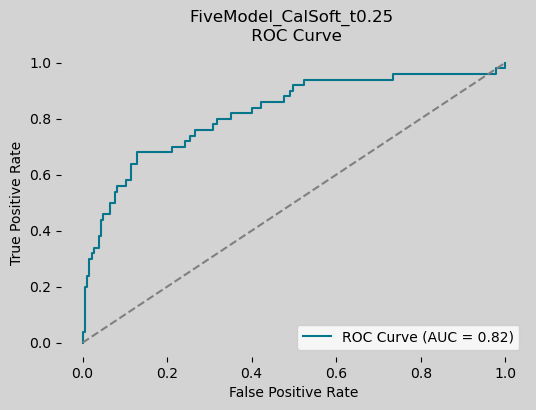

In [31]:
# ROC Curve Plot (FiveModel_CalSoft_t0.25)
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, ROC_AUC, model_name):
    """
    ROC Curve Plot
    """
    plt.figure(figsize=(6,4), facecolor='lightgrey')
    plt.plot(fpr, tpr, color='#06768d', label=f'ROC Curve (AUC = {ROC_AUC:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('FiveModel_CalSoft_t0.25 \n ROC Curve')
    plt.legend(loc='lower right')
    ax = plt.gca()
    ax.set_facecolor('lightgrey')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/results/{model_name}_PR_Curve.png")
    plt.show()

model_name = "FiveModel_CalSoft_t0.25"
y_proba = voter_calsoft_025.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
ROC_AUC = roc_auc_score(y_test, y_proba)
plot_roc_curve(fpr, tpr, ROC_AUC, model_name=model_name)


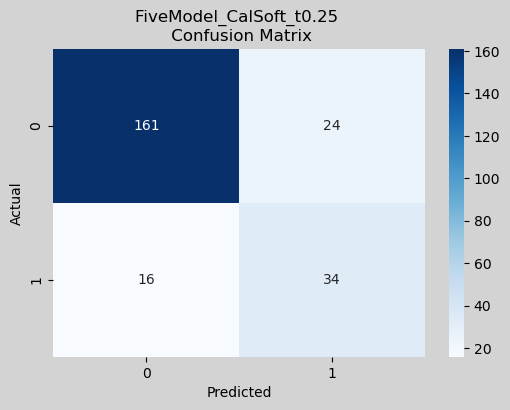

In [36]:
# Confusion Matrix Plot (FiveModel_CalSoft_t0.25)

def plot_confusion_matrix(cm, model_name, class_labels=None):
    """
    Plot Confusion Matrix
    """
    if class_labels is None:
        labels_to_use = [str(i) for i in range(cm.shape[0])]
    else:
        labels_to_use = [str(label) for label in class_labels]

    plt.figure(figsize=(6,4), facecolor='lightgrey')
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_to_use, \
                yticklabels=labels_to_use)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('FiveModel_CalSoft_t0.25 \n Confusion Matrix')
    plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/results/{model_name}_CM.png")
    plt.show()

model_name = "FiveModel_CalSoft_t0.25"
y_proba = voter_calsoft_025.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, model_name=model_name, class_labels=[0, 1])


/var/folders/9n/my6phbv923z13rq9j99h3qz40000gn/T/ipykernel_15588/458149896.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Importance", y="Feature", data=perm_df, palette='crest_r')


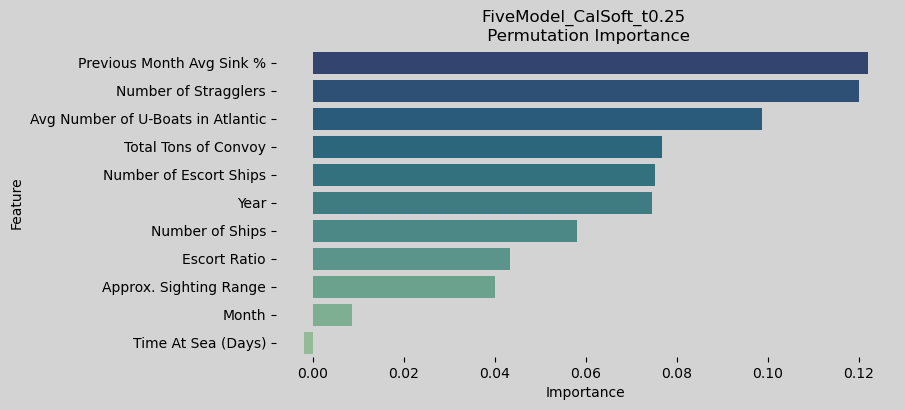

,Feature,Importance
9,Previous Month Avg Sink %,0.122000
2,Number of Stragglers,0.120000
4,Avg Number of U-Boats in Atlantic,0.098667
3,Total Tons of Convoy,0.076667
1,Number of Escort Ships,0.075333
8,Year,0.074667
0,Number of Ships,0.058000
5,Escort Ratio,0.043333
10,Approx. Sighting Range,0.040000
7,Month,0.008667


In [33]:
# Permutation Importance (FiveModel_CalSoft_t0.25)
from sklearn.inspection import permutation_importance

model_name = "FiveModel_CalSoft_t0.25"
perm = permutation_importance(
    voter_calsoft_025,
    X_test,
    y_test,
    n_repeats=30,
    random_state=1945,
    scoring="recall",
)

perm_df = pd.DataFrame({
    "Feature": feature_names[:len(perm.importances_mean)],
    "Importance": perm.importances_mean,
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,4), facecolor='lightgrey')
ax = sns.barplot(x="Importance", y="Feature", data=perm_df, palette='crest_r')
plt.title('FiveModel_CalSoft_t0.25 \n Permutation Importance')
ax.set_facecolor('lightgrey')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/results/{model_name}_Permutation_Importance.png")
plt.show()
perm_df


/var/folders/9n/my6phbv923z13rq9j99h3qz40000gn/T/ipykernel_15588/4140140804.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Importance", y="Feature", data=agg_df, palette='crest_r')


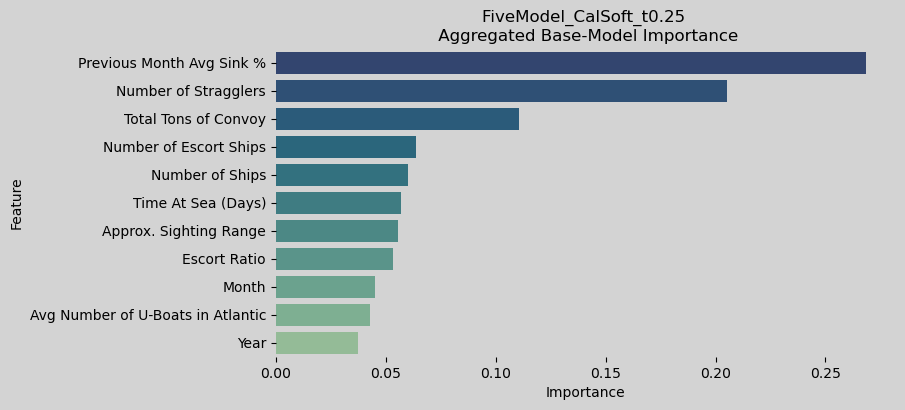

In [34]:
# Aggregated Base-Model Importance (FiveModel_CalSoft_t0.25)

def _extract_importance_from_estimator(est):
    if hasattr(est, "named_steps") and "model" in est.named_steps:
        est = est.named_steps["model"]
    if hasattr(est, "feature_importances_"):
        return np.asarray(est.feature_importances_)
    if hasattr(est, "coef_"):
        coef = np.asarray(est.coef_)
        if coef.ndim == 1:
            return np.abs(coef)
        return np.mean(np.abs(coef), axis=0)
    return None

def _unwrap_calibrated(est):
    if hasattr(est, "calibrated_classifiers_") and len(est.calibrated_classifiers_) > 0:
        imps = []
        for cc in est.calibrated_classifiers_:
            base = getattr(cc, "estimator", None)
            if base is None:
                continue
            imp = _extract_importance_from_estimator(base)
            if imp is not None:
                imps.append(np.asarray(imp))
        if imps:
            min_len = min(len(i) for i in imps)
            return np.mean([i[:min_len] for i in imps], axis=0)
    return _extract_importance_from_estimator(est)

model_name = "FiveModel_CalSoft_t0.25"
base_imps = []
for est in voter_calsoft_025.estimators_:
    imp = _unwrap_calibrated(est)
    if imp is not None:
        base_imps.append(np.asarray(imp))

if not base_imps:
    print('No base estimators exposed feature importances/coefficients.')
else:
    min_len = min(len(i) for i in base_imps)
    agg_imp = np.mean([i[:min_len] for i in base_imps], axis=0)
    agg_df = pd.DataFrame({
        "Feature": feature_names[:len(agg_imp)],
        "Importance": agg_imp,
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(8,4), facecolor='lightgrey')
    ax = sns.barplot(x="Importance", y="Feature", data=agg_df, palette='crest_r')
    plt.title('FiveModel_CalSoft_t0.25 \n Aggregated Base-Model Importance')
    ax.set_facecolor('lightgrey')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/results/{model_name}_Aggregated_Importance.png")
    plt.show()
    agg_df


/var/folders/9n/my6phbv923z13rq9j99h3qz40000gn/T/ipykernel_15588/3172439006.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Importance", y="Feature", data=shap_df, palette='crest_r')


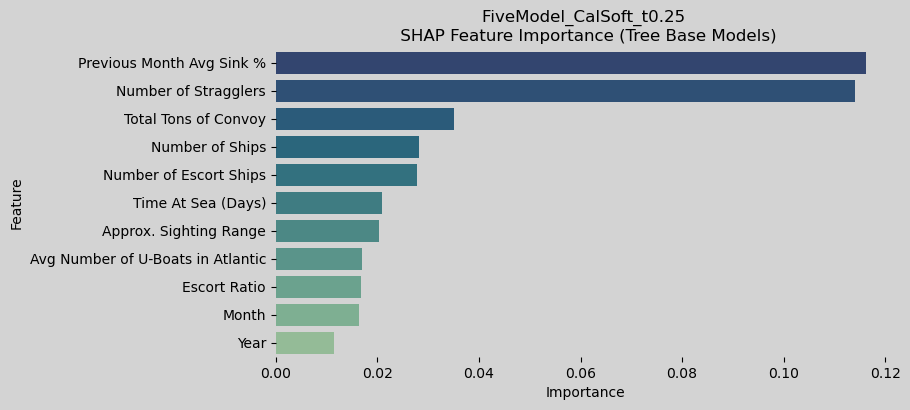

In [35]:
# SHAP Importance (Tree Models in FiveModel_CalSoft_t0.25)

model_name = "FiveModel_CalSoft_t0.25"
try:
    import shap
except ImportError:
    print("SHAP is not installed. Install with: pip install shap")
else:
    shap_imps = []

    def _unwrap_for_shap(est):
        if hasattr(est, "calibrated_classifiers_") and len(est.calibrated_classifiers_) > 0:
            return getattr(est.calibrated_classifiers_[0], "estimator", est)
        return est

    n_features = X_test.shape[1]
    active_feature_names = feature_names[:n_features]

    for est in voter_calsoft_025.estimators_:
        base = _unwrap_for_shap(est)
        if hasattr(base, "named_steps") and "model" in base.named_steps:
            base = base.named_steps["model"]

        if not hasattr(base, "predict"):
            continue

        try:
            explainer = shap.TreeExplainer(base)
            shap_vals = explainer.shap_values(X_test)

            if isinstance(shap_vals, list):
                vals = np.asarray(shap_vals[-1])
            else:
                vals = np.asarray(shap_vals)

            mean_abs = np.mean(np.abs(vals), axis=0)
            mean_abs = np.asarray(mean_abs).squeeze()

            if mean_abs.ndim > 1:
                if mean_abs.shape[0] == n_features:
                    mean_abs = np.mean(mean_abs, axis=tuple(range(1, mean_abs.ndim)))
                elif mean_abs.shape[-1] == n_features:
                    mean_abs = np.mean(mean_abs, axis=tuple(range(0, mean_abs.ndim - 1)))
                else:
                    mean_abs = np.ravel(mean_abs)[:n_features]

            mean_abs = np.ravel(mean_abs)
            if mean_abs.size >= n_features:
                shap_imps.append(mean_abs[:n_features])
        except Exception:
            continue

    if not shap_imps:
        print('No compatible tree estimators available for SHAP in this ensemble.')
    else:
        min_len = min(len(i) for i in shap_imps)
        shap_mean = np.mean([i[:min_len] for i in shap_imps], axis=0)
        shap_mean = np.ravel(shap_mean)

        shap_df = pd.DataFrame({
            "Feature": active_feature_names[:len(shap_mean)],
            "Importance": shap_mean,
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(8,4), facecolor='lightgrey')
        ax = sns.barplot(x="Importance", y="Feature", data=shap_df, palette='crest_r')
        plt.title('FiveModel_CalSoft_t0.25 \n SHAP Feature Importance (Tree Base Models)')
        ax.set_facecolor('lightgrey')
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/results/{model_name}_SHAP_Importance.png")
        plt.show()
        shap_df


In [19]:
# Keep metadata BEFORE dropping columns for X
raw_df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
raw_df = raw_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)

# Match the model-training preprocessing
model_df = raw_df.drop(columns=[
    'Convoy Number',
    'Number of Ships Sunk',
    'Depart_Date',
    'Arrival/Dispersal Date',
    'Number of Escorts Sunk',
    'Number of Stragglers Sunk',
    'Total Tons of Ships Sunk',
    'Escort Sink Percentage',
    'Straggler Sink Percentage',
])
model_df['Risk'] = (model_df['Overall Sink Percentage'] > 0).astype(int)
X_df = model_df.drop(columns=['Overall Sink Percentage', 'Risk'])
y_arr = model_df['Risk'].values

# Split with row indices so we can map back to full original rows
row_idx = np.arange(len(X_df))
_, X_test_meta, _, y_test_meta, _, idx_test = train_test_split(
    X_df,
    y_arr,
    row_idx,
    train_size=0.8,
    random_state=1945,
    stratify=y_arr,
)

# Ensemble predictions on the same split definition
y_proba = voter_calsoft_025.predict_proba(X_test_meta)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)

# Full original dataframe with test predictions attached
all_rows_scored = raw_df.copy()
all_rows_scored['At Risk (0/1)'] = np.nan
all_rows_scored['Predicted At Risk (0/1)'] = np.nan
all_rows_scored['Pred_Prob'] = np.nan
all_rows_scored['Is_Test'] = False
all_rows_scored['Is_False_Negative'] = False

all_rows_scored.loc[idx_test, 'At Risk (0/1)'] = y_test_meta
all_rows_scored.loc[idx_test, 'Predicted At Risk (0/1)'] = y_pred
all_rows_scored.loc[idx_test, 'Pred_Prob'] = y_proba
all_rows_scored.loc[idx_test, 'Is_Test'] = True
all_rows_scored.loc[idx_test, 'Is_False_Negative'] = (y_test_meta == 1) & (y_pred == 0)

false_negatives = all_rows_scored[all_rows_scored['Is_False_Negative']].copy()
false_negatives = false_negatives.sort_values('Pred_Prob')
false_negatives = false_negatives.drop(columns=['Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', 'Number of Stragglers Sunk', 
                                                'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
# View full original dataframe with predictions/flags
all_rows_scored

# View only false negatives

# false_negatives.columns
false_negatives



,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range,At Risk (0/1),Predicted At Risk (0/1),Pred_Prob,Is_Test,Is_False_Negative
1026,HX.305,124.0,27.0,0.0,2.0,712910.0,1.612903,35.0,0.217742,16.0,8.0,1944.0,0.000000,23.999958,1.0,0.0,0.079620,True,True
1028,ON.251,160.0,19.0,0.0,1.0,888682.0,0.625000,47.0,0.118750,18.0,9.0,1944.0,0.161290,23.999999,1.0,0.0,0.085659,True,True
1141,HX.348,113.0,34.0,1.0,2.0,586337.0,1.769912,53.0,0.300885,17.0,4.0,1945.0,0.070872,23.999865,1.0,0.0,0.115779,True,True
467,ON.4,78.0,21.0,0.0,1.0,199904.0,1.282051,35.0,0.269231,12.0,8.0,1941.0,0.000000,23.994606,1.0,0.0,0.145826,True,True
989,SC.157,78.0,16.0,1.0,1.0,261438.0,1.282051,43.0,0.205128,14.0,4.0,1944.0,0.234742,23.994606,1.0,0.0,0.150501,True,True
481,SC.42,101.0,29.0,1.0,16.0,271397.0,15.841584,35.0,0.287129,21.0,8.0,1941.0,0.000000,23.999522,1.0,0.0,0.153084,True,True
542,SC.57,57.0,18.0,0.0,3.0,195397.0,5.263158,32.0,0.315789,17.0,11.0,1941.0,1.410462,23.950699,1.0,0.0,0.156553,True,True
477,SC.41,97.0,18.0,1.0,1.0,276143.0,1.030928,35.0,0.185567,18.0,8.0,1941.0,0.000000,23.999271,1.0,0.0,0.165843,True,True
899,ON.202,70.0,29.0,0.0,10.0,281952.0,14.285714,56.0,0.414286,16.0,9.0,1943.0,0.000000,23.987468,1.0,0.0,0.170059,True,True
579,ON.60,66.0,15.0,0.0,4.0,232049.0,6.060606,35.0,0.227273,20.0,1.0,1942.0,0.348548,23.980900,1.0,0.0,0.180151,True,True


In [20]:
# Keep metadata BEFORE dropping columns for X (False Positives)
raw_df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
raw_df = raw_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)

# Match the model-training preprocessing
model_df = raw_df.drop(columns=[
    'Convoy Number',
    'Number of Ships Sunk',
    'Depart_Date',
    'Arrival/Dispersal Date',
    'Number of Escorts Sunk',
    'Number of Stragglers Sunk',
    'Total Tons of Ships Sunk',
    'Escort Sink Percentage',
    'Straggler Sink Percentage',
])
model_df['Risk'] = (model_df['Overall Sink Percentage'] > 0).astype(int)
X_df = model_df.drop(columns=['Overall Sink Percentage', 'Risk'])
y_arr = model_df['Risk'].values

# Split with row indices so we can map back to full original rows
row_idx = np.arange(len(X_df))
_, X_test_meta, _, y_test_meta, _, idx_test = train_test_split(
    X_df,
    y_arr,
    row_idx,
    train_size=0.8,
    random_state=1945,
    stratify=y_arr,
)

# Ensemble predictions on the same split definition
y_proba = voter_calsoft_025.predict_proba(X_test_meta)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)

# Full original dataframe with test predictions attached
all_rows_scored = raw_df.copy()
all_rows_scored['At Risk (0/1)'] = np.nan
all_rows_scored['Predicted At Risk (0/1)'] = np.nan
all_rows_scored['Pred_Prob'] = np.nan
all_rows_scored['Is_Test'] = False
all_rows_scored['Is_False_Positive'] = False

all_rows_scored.loc[idx_test, 'At Risk (0/1)'] = y_test_meta
all_rows_scored.loc[idx_test, 'Predicted At Risk (0/1)'] = y_pred
all_rows_scored.loc[idx_test, 'Pred_Prob'] = y_proba
all_rows_scored.loc[idx_test, 'Is_Test'] = True
all_rows_scored.loc[idx_test, 'Is_False_Positive'] = (y_test_meta == 0) & (y_pred == 1)

false_positives = all_rows_scored[all_rows_scored['Is_False_Positive']].copy()
false_positives = false_positives.sort_values('Pred_Prob', ascending=False)
false_positives = false_positives.drop(columns=['Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', 'Number of Stragglers Sunk', 
                                                'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
# View full original dataframe with predictions/flags
all_rows_scored

# View only false positives
false_positives


,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range,At Risk (0/1),Predicted At Risk (0/1),Pred_Prob,Is_Test,Is_False_Positive
260,OB.232,49.0,13.0,1.0,0.0,133451.0,0.0,7.0,0.265306,5.0,10.0,1940.0,4.403733,23.885472,0.0,1.0,0.526038,True,True
370,OB.295,45.0,13.0,1.0,0.0,194203.0,0.0,15.0,0.288889,6.0,3.0,1941.0,2.951790,23.825441,0.0,1.0,0.456349,True,True
34,OB.33,35.0,3.0,1.0,0.0,181786.0,0.0,4.0,0.085714,5.0,11.0,1939.0,1.823096,23.499369,0.0,1.0,0.446923,True,True
569,HX.169,58.0,16.0,13.0,0.0,331093.0,0.0,35.0,0.275862,15.0,1.0,1942.0,0.348548,23.955629,0.0,1.0,0.442252,True,True
819,ON.177,43.0,16.0,1.0,0.0,177506.0,0.0,110.0,0.372093,17.0,4.0,1943.0,2.846717,23.784495,0.0,1.0,0.433760,True,True
516,ON.29,63.0,27.0,3.0,0.0,154025.0,0.0,30.0,0.428571,14.0,10.0,1941.0,1.518216,23.973800,0.0,1.0,0.427426,True,True
694,HX.201,49.0,16.0,1.0,0.0,207402.0,0.0,82.0,0.326531,12.0,8.0,1942.0,1.848510,23.885472,0.0,1.0,0.426489,True,True
183,HX.59,62.0,7.0,3.0,0.0,285514.0,0.0,5.0,0.112903,15.0,7.0,1940.0,1.120695,23.970888,0.0,1.0,0.401511,True,True
661,HX.193,50.0,13.0,1.0,0.0,228225.0,0.0,61.0,0.260000,12.0,6.0,1942.0,1.033101,23.896924,0.0,1.0,0.380124,True,True
374,OB.297,53.0,12.0,0.0,0.0,254213.0,0.0,15.0,0.226415,5.0,3.0,1941.0,2.951790,23.924858,0.0,1.0,0.371803,True,True


In [21]:
# Keep metadata BEFORE dropping columns for X (True Positives)
raw_df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
raw_df = raw_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)

# Match the model-training preprocessing
model_df = raw_df.drop(columns=[
    'Convoy Number',
    'Number of Ships Sunk',
    'Depart_Date',
    'Arrival/Dispersal Date',
    'Number of Escorts Sunk',
    'Number of Stragglers Sunk',
    'Total Tons of Ships Sunk',
    'Escort Sink Percentage',
    'Straggler Sink Percentage',
])
model_df['Risk'] = (model_df['Overall Sink Percentage'] > 0).astype(int)
X_df = model_df.drop(columns=['Overall Sink Percentage', 'Risk'])
y_arr = model_df['Risk'].values

# Split with row indices so we can map back to full original rows
row_idx = np.arange(len(X_df))
_, X_test_meta, _, y_test_meta, _, idx_test = train_test_split(
    X_df,
    y_arr,
    row_idx,
    train_size=0.8,
    random_state=1945,
    stratify=y_arr,
)

# Ensemble predictions on the same split definition
y_proba = voter_calsoft_025.predict_proba(X_test_meta)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)

# Full original dataframe with test predictions attached
all_rows_scored = raw_df.copy()
all_rows_scored['At Risk (0/1)'] = np.nan
all_rows_scored['Predicted At Risk (0/1)'] = np.nan
all_rows_scored['Pred_Prob'] = np.nan
all_rows_scored['Is_Test'] = False
all_rows_scored['Is_True_Positive'] = False

all_rows_scored.loc[idx_test, 'At Risk (0/1)'] = y_test_meta
all_rows_scored.loc[idx_test, 'Predicted At Risk (0/1)'] = y_pred
all_rows_scored.loc[idx_test, 'Pred_Prob'] = y_proba
all_rows_scored.loc[idx_test, 'Is_Test'] = True
all_rows_scored.loc[idx_test, 'Is_True_Positive'] = (y_test_meta == 1) & (y_pred == 1)

true_positives = all_rows_scored[all_rows_scored['Is_True_Positive']].copy()
true_positives = true_positives.sort_values('Pred_Prob', ascending=False)
true_positives = true_positives.drop(columns=['Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', 'Number of Stragglers Sunk', 
                                                'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
# View full original dataframe with predictions/flags
all_rows_scored

# View only true positives
true_positives


,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range,At Risk (0/1),Predicted At Risk (0/1),Pred_Prob,Is_Test,Is_True_Positive
240,SC.6,45.0,6.0,2.0,4.0,119904.0,8.888889,7.0,0.133333,15.0,9.0,1940.0,3.187659,23.825441,1.0,1.0,0.542373,True,True
259,HX.82,57.0,17.0,4.0,1.0,238760.0,1.754386,7.0,0.298246,17.0,10.0,1940.0,4.403733,23.950699,1.0,1.0,0.533673,True,True
771,ON.156,52.0,17.0,5.0,1.0,145388.0,1.923077,98.0,0.326923,24.0,12.0,1942.0,2.147390,23.916509,1.0,1.0,0.524396,True,True
343,HX.106,52.0,11.0,12.0,2.0,279496.0,3.846154,12.0,0.211538,19.0,1.0,1941.0,0.812526,23.916509,1.0,1.0,0.523747,True,True
238,HX.76,51.0,12.0,1.0,1.0,207957.0,1.960784,7.0,0.235294,14.0,9.0,1940.0,3.187659,23.907232,1.0,1.0,0.515471,True,True
221,HX.71,41.0,8.0,1.0,2.0,174151.0,4.878049,7.0,0.195122,15.0,9.0,1940.0,3.187659,23.733944,1.0,1.0,0.514015,True,True
815,ON.176,68.0,21.0,1.0,2.0,312502.0,2.941176,114.0,0.308824,20.0,3.0,1943.0,4.153262,23.984529,1.0,1.0,0.513610,True,True
822,HX.234,67.0,21.0,1.0,2.0,344893.0,2.985075,110.0,0.313433,17.0,4.0,1943.0,2.846717,23.982810,1.0,1.0,0.513254,True,True
293,HX.92,32.0,8.0,1.0,4.0,122992.0,12.500000,8.0,0.250000,13.0,11.0,1940.0,3.637440,23.313263,1.0,1.0,0.506756,True,True
365,SC.24,36.0,8.0,1.0,1.0,113573.0,2.777778,11.0,0.222222,19.0,2.0,1941.0,1.714611,23.549432,1.0,1.0,0.470156,True,True


In [22]:
# Keep metadata BEFORE dropping columns for X (True Negatives)
raw_df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
raw_df = raw_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)

# Match the model-training preprocessing
model_df = raw_df.drop(columns=[
    'Convoy Number',
    'Number of Ships Sunk',
    'Depart_Date',
    'Arrival/Dispersal Date',
    'Number of Escorts Sunk',
    'Number of Stragglers Sunk',
    'Total Tons of Ships Sunk',
    'Escort Sink Percentage',
    'Straggler Sink Percentage',
])
model_df['Risk'] = (model_df['Overall Sink Percentage'] > 0).astype(int)
X_df = model_df.drop(columns=['Overall Sink Percentage', 'Risk'])
y_arr = model_df['Risk'].values

# Split with row indices so we can map back to full original rows
row_idx = np.arange(len(X_df))
_, X_test_meta, _, y_test_meta, _, idx_test = train_test_split(
    X_df,
    y_arr,
    row_idx,
    train_size=0.8,
    random_state=1945,
    stratify=y_arr,
)

# Ensemble predictions on the same split definition
y_proba = voter_calsoft_025.predict_proba(X_test_meta)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)

# Full original dataframe with test predictions attached
all_rows_scored = raw_df.copy()
all_rows_scored['At Risk (0/1)'] = np.nan
all_rows_scored['Predicted At Risk (0/1)'] = np.nan
all_rows_scored['Pred_Prob'] = np.nan
all_rows_scored['Is_Test'] = False
all_rows_scored['Is_True_Negative'] = False

all_rows_scored.loc[idx_test, 'At Risk (0/1)'] = y_test_meta
all_rows_scored.loc[idx_test, 'Predicted At Risk (0/1)'] = y_pred
all_rows_scored.loc[idx_test, 'Pred_Prob'] = y_proba
all_rows_scored.loc[idx_test, 'Is_Test'] = True
all_rows_scored.loc[idx_test, 'Is_True_Negative'] = (y_test_meta == 0) & (y_pred == 0)

true_negatives = all_rows_scored[all_rows_scored['Is_True_Negative']].copy()
true_negatives = true_negatives.sort_values('Pred_Prob', ascending=True)
true_negatives = true_negatives.drop(columns=['Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', 'Number of Stragglers Sunk', 
                                                'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
# View full original dataframe with predictions/flags
all_rows_scored

# View only true negatives
true_negatives


,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range,At Risk (0/1),Predicted At Risk (0/1),Pred_Prob,Is_Test,Is_True_Negative
1016,ON.246,125.0,18.0,0.0,0.0,758931.0,0.0,26.0,0.144000,15.0,7.0,1944.0,0.000000,23.999962,0.0,0.0,0.085027,True,True
1017,HX.301,153.0,33.0,0.0,0.0,839646.0,0.0,26.0,0.215686,14.0,7.0,1944.0,0.000000,23.999998,0.0,0.0,0.085175,True,True
1009,ON.242,112.0,18.0,0.0,0.0,598708.0,0.0,43.0,0.160714,16.0,6.0,1944.0,0.000000,23.999850,0.0,0.0,0.085199,True,True
996,HX.291,115.0,18.0,0.0,0.0,612477.0,0.0,32.0,0.156522,17.0,5.0,1944.0,0.142450,23.999891,0.0,0.0,0.085571,True,True
1169,ON.304,85.0,15.0,0.0,0.0,511572.0,0.0,0.0,0.176471,15.0,5.0,1945.0,0.098328,23.997420,0.0,0.0,0.086096,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,SC.113,76.0,14.0,0.0,0.0,317787.0,0.0,98.0,0.184211,21.0,12.0,1942.0,2.147390,23.993340,0.0,0.0,0.236440,True,True
416,SC.31,56.0,21.0,0.0,0.0,142227.0,0.0,16.0,0.375000,21.0,5.0,1941.0,1.562314,23.945221,0.0,0.0,0.241867,True,True
848,SC.132,68.0,22.0,0.0,0.0,248804.0,0.0,116.0,0.323529,16.0,5.0,1943.0,2.114021,23.984529,0.0,0.0,0.247723,True,True
235,HX.75,73.0,12.0,0.0,0.0,329370.0,0.0,7.0,0.164384,16.0,9.0,1940.0,3.187659,23.990864,0.0,0.0,0.247917,True,True


In [23]:
# Compare describe() metrics across FN / FP / TP / TN
def compare_confusion_group_describes(
    false_negatives,
    false_positives,
    true_positives,
    true_negatives,
    include='all',
):
    groups = {
        'False_Negatives': false_negatives,
        'False_Positives': false_positives,
        'True_Positives': true_positives,
        'True_Negatives': true_negatives,
    }

    summary = {}
    for name, frame in groups.items():
        if frame is None or frame.empty:
            summary[name] = pd.DataFrame()
            continue

        if include == 'numeric':
            desc = frame.describe(include=[np.number]).T
        elif include == 'categorical':
            desc = frame.describe(include=['object', 'category', 'bool']).T
        else:
            desc = frame.describe(include='all').T

        summary[name] = desc

    non_empty = {k: v for k, v in summary.items() if not v.empty}
    if not non_empty:
        return summary, pd.DataFrame()

    combined = pd.concat(non_empty, axis=1)
    return summary, combined


In [30]:
# Run comparison tables
numeric_summary, numeric_compare = compare_confusion_group_describes(
    false_negatives,
    false_positives,
    true_positives,
    true_negatives,
    include='numeric',
)

all_summary, all_compare = compare_confusion_group_describes(
    false_negatives,
    false_positives,
    true_positives,
    true_negatives,
    include='all',
)

#Save To  Excel File:
numeric_compare.to_excel('/Users/matthewplambeck/Desktop/Convoy Predictor/results/Confusion_Matrix_Stats_Compare.xlsx')
numeric_compare


False_Negatives                 \
                                            count           mean   
Number of Ships                              16.0      73.687500   
Number of Escort Ships                       16.0      16.937500   
Number of Stragglers                         16.0       0.312500   
Number of Ships Sunk                         16.0       4.062500   
Total Tons of Convoy                         16.0  314616.937500   
Overall Sink Percentage                      16.0       6.672653   
Avg Number of U-Boats in Atlantic            16.0      34.500000   
Escort Ratio                                 16.0       0.223268   
Time At Sea (Days)                           16.0      14.187500   
Month                                        16.0       6.812500   
Year                                         16.0    1941.812500   
Previous Month Avg Sink %                    16.0       0.793316   
Approx. Sighting Range                       16.0      23.670316   
At Risk (0/1)                                16.0       1.000000   
Predicted At Risk (0/1)                      16.0       0.000000   
Pred_Prob                                    16.0       0.160819   

                                                                               \
                                             std           min            25%   
Number of Ships                        37.758388     16.000000      46.750000   
Number of Escort Ships                  9.787535      2.000000      11.500000   
Number of Stragglers                    0.478714      0.000000       0.000000   
Number of Ships Sunk                    4.682859      1.000000       1.000000   
Total Tons of Convoy               219992.710122  78633.000000  198777.250000   
Overall Sink Percentage                 6.644469      0.625000       1.530190   
Avg Number of U-Boats in Atlantic      27.577769      2.000000      12.500000   
Escort Ratio                            0.093502      0.078947       0.142952   
Time At Sea (Days)                      5.647640      3.000000      13.500000   
Month                                   3.037954      1.000000       4.000000   
Year                                    1.796988   1939.000000    1940.750000   
Previous Month Avg Sink %               1.207144      0.000000       0.000000   
Approx. Sighting Range                  0.922360     20.293960      23.854679   
At Risk (0/1)                           0.000000      1.000000       1.000000   
Predicted At Risk (0/1)                 0.000000      0.000000       0.000000   
Pred_Prob                               0.039064      0.079620       0.149332   

                                                                 \
                                             50%            75%   
Number of Ships                        68.000000      98.000000   
Number of Escort Ships                 17.500000      22.500000   
Number of Stragglers                    0.000000       1.000000   
Number of Ships Sunk                    2.000000       4.000000   
Total Tons of Convoy               253543.000000  281658.750000   
Overall Sink Percentage                 4.244482      11.019737   
Avg Number of U-Boats in Atlantic      35.000000      44.000000   
Escort Ratio                            0.222507       0.289908   
Time At Sea (Days)                     16.000000      17.250000   
Month                                   7.500000       8.250000   
Year                                 1941.000000    1943.250000   
Previous Month Avg Sink %               0.198016       1.120695   
Approx. Sighting Range                 23.984184      23.999334   
At Risk (0/1)                           1.000000       1.000000   
Predicted At Risk (0/1)                 0.000000       0.000000   
Pred_Prob                               0.167951       0.186614   

                                                 False_Positives  \
                                             max           count   
Number 